# Imports


In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import InceptionV3, VGG16, VGG19, DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, accuracy_score
import seaborn as sns
from keras.regularizers import l2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
import time
import os

# Data Proccesing 

In [2]:
# Set the path to the dataset directory
BASEPATH = "/kaggle/input/dog-pose/dog-pose-class/images"
annot_path = "/kaggle/input/dog-pose/dog-pose-class/releases/2/annotations"

In [3]:
# create an empty list to store the results
results = []

# iterate over each file in the directory
for file_name in os.listdir(annot_path):
    if file_name.endswith('.json'):
        # read the JSON file
        with open(os.path.join(annot_path, file_name), 'r') as f:
            json_data = json.load(f)
        try:
            # extract the necessary fields
            file_path = f"{BASEPATH}/{json_data['item']['slots'][0]['source_files'][0]['file_name']}"
            label = json_data['annotations'][0]['name']
            # append the results to the list
            results.append({'Filepath': file_path, 'Label': label})
        except Exception as e:
#             print(f"File name: {file_name} cannot mem loaded.")
            pass

# convert the results list to a dataframe
df = pd.DataFrame(results)

In [4]:
print('Total number of images:', len(df))

Total number of images: 2697


In [5]:
df.head()

,Filepath,Label
0,/kaggle/input/dog-pose/dog-pose-class/images/n...,Standing
1,/kaggle/input/dog-pose/dog-pose-class/images/n...,Sitting
2,/kaggle/input/dog-pose/dog-pose-class/images/n...,Standing
3,/kaggle/input/dog-pose/dog-pose-class/images/n...,Lying
4,/kaggle/input/dog-pose/dog-pose-class/images/n...,Sitting


In [6]:
# Get the count of each dog breed in the dataset
label_count = pd.value_counts(df['Label'], ascending=False)
print('Dog poses:')
print(label_count.tail(3))

Dog poses:
Standing    1201
Lying        884
Sitting      612
Name: Label, dtype: int64


## Normalize the amount of data per class

In [7]:
# Get the unique labels and their frequencies
label_counts = df["Label"].value_counts()
unique_labels = label_counts.index.tolist()

# Determine the number of samples to use for each label
num_samples_per_label = label_counts.min()

# Group the data by label
grouped_data = df.groupby("Label")

# Sample a fixed number of samples from each group
sampled_data = pd.DataFrame(columns=["Filepath", "Label"])
for label in unique_labels:
    label_data = grouped_data.get_group(label)
    sampled_indices = np.random.choice(len(label_data), num_samples_per_label, replace=False)
    sampled_data = sampled_data.append(label_data.iloc[sampled_indices])
    
df = sampled_data.reset_index(drop=True)

In [8]:
# Get the count of each dog breed in the dataset
label_count = df.value_counts(df['Label'], ascending=False)
print('Dog poses:')
print(label_count.tail(3))

Dog poses:
Label
Lying       612
Sitting     612
Standing    612
dtype: int64


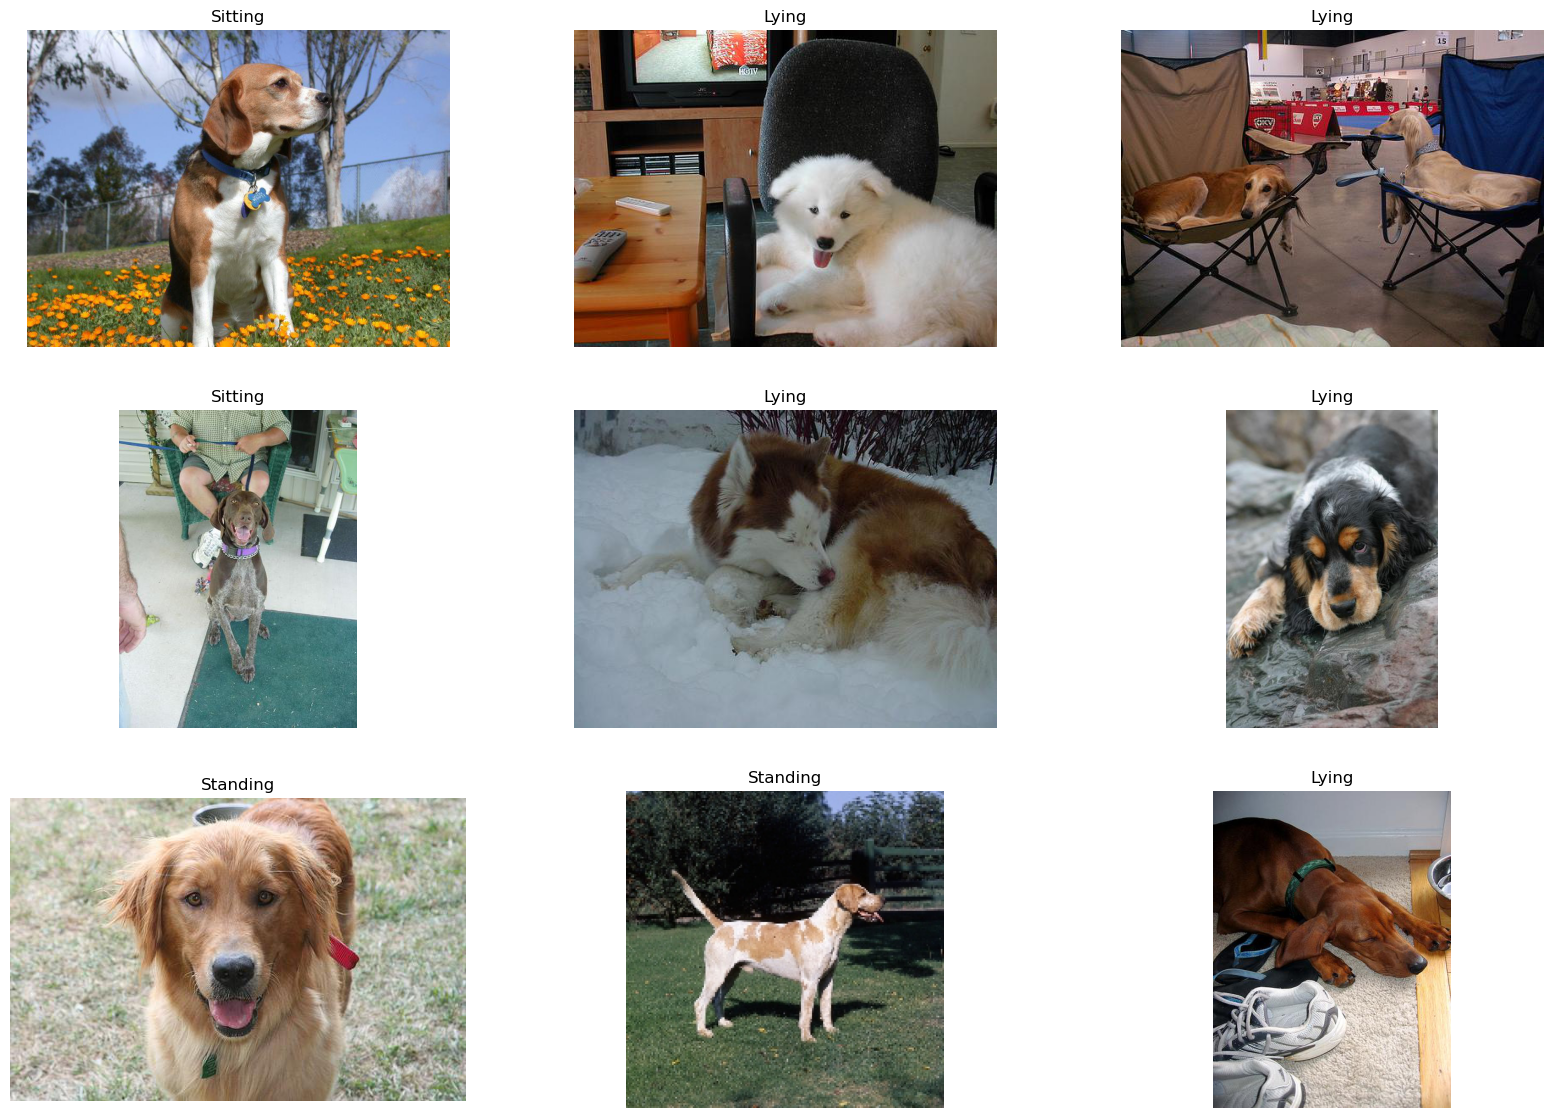

In [9]:
# Randomly select a subset of samples to display
num_samples_to_display = 9
sample_indices = np.random.choice(len(df), num_samples_to_display, replace=False)
sample_df = df.iloc[sample_indices]

# Display the sample images
fig, axis = plt.subplots(num_samples_to_display//3, 3, figsize=(20, 14))
for i, ax in enumerate(axis.flat):
    ax.imshow(plt.imread(sample_df.Filepath.iloc[i]))
    ax.set_title(sample_df.Label.iloc[i])
    ax.axis('off')
plt.show()

# Making the data split

In [10]:
# Split the dataset into training, validation, and testing sets
val_ratio = test_ratio = 0.2
train, test = train_test_split(df, test_size=test_ratio)
val, test = train_test_split(test, test_size=val_ratio)
print('Total number of samples:', len(df))
print('Number of training samples:', len(train))
print('Number of validation samples:', len(val))
print('Number of testing samples:', len(test))

Total number of samples: 1836
Number of training samples: 1468
Number of validation samples: 294
Number of testing samples: 74


In [11]:
# Create an ImageDataGenerator object to augment the training data
img_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=30, 
    width_shift_range=0.2,
    height_shift_range=0.2, 
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [12]:
batch_size = 8
# target_size=(299, 299)
target_size=(224, 224)

# Create generators for the training, validation, and testing sets
train_generator = img_datagen.flow_from_dataframe(
    dataframe=train,
    x_col="Filepath",
    y_col="Label",
    batch_size=batch_size,
    shuffle=True,
    target_size=target_size
)

validation_generator = img_datagen.flow_from_dataframe(
    dataframe=val,
    x_col="Filepath",
    y_col="Label",
    batch_size=batch_size,
    shuffle=True,
    target_size=target_size
)


test_generator = test_datagen.flow_from_dataframe(
    dataframe=test,
    x_col="Filepath",
    y_col="Label",
    batch_size=batch_size,
    shuffle=False,
    target_size=target_size
)


Found 1468 validated image filenames belonging to 3 classes.
Found 294 validated image filenames belonging to 3 classes.
Found 74 validated image filenames belonging to 3 classes.


# Model 

In [13]:
input_shape = target_size + (3,)

# with tpu_strategy.scope():
# Load the model without the top layers
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)

# Get the base model name
base_model_name = "DenseNet121"

# Freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Add your own custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x) # Add L2 regularization to this layer
x = Dropout(0.2)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)

predictions = Dense(len(unique_labels), activation='softmax')(x)

# Create the new model
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

# print(model.summary())

In [14]:
# Check what is the status of the last 100 layers
for layer in model.layers[-10:]:
    print(f"Layer: {layer.name}, Trainable: {layer.trainable}")

Layer: global_average_pooling2d, Trainable: True
Layer: dense, Trainable: True
Layer: dropout, Trainable: True
Layer: dense_1, Trainable: True
Layer: dropout_1, Trainable: True
Layer: dense_2, Trainable: True
Layer: dropout_2, Trainable: True
Layer: dense_3, Trainable: True
Layer: dropout_3, Trainable: True
Layer: dense_4, Trainable: True


In [15]:
# Define the callbacks

# Get the current timestamp
timestamp = time.strftime("%Y_%m_%d-%H%_M")

# Create the ModelCheckpoint callback for validation loss
checkpoint_loss_filepath = f'{base_model_name}_best_model_loss_{timestamp}.h5'
checkpoint_loss_callback = ModelCheckpoint(
    filepath=checkpoint_loss_filepath,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

# Create the ModelCheckpoint callback for validation accuracy
checkpoint_accuracy_filepath = f'{base_model_name}_best_model_accuracy_{timestamp}.h5'
checkpoint_accuracy_callback = ModelCheckpoint(
    filepath=checkpoint_accuracy_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

# a reducing lr callback to reduce lr when val_loss doesn't decrease
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, verbose=1, mode='min',
                              min_delta=0.0001, cooldown=2, min_lr=1e-7)

# for early stopping
early_stop = EarlyStopping(monitor="val_loss", mode="min", patience=4)


callbacks = [checkpoint_loss_callback, checkpoint_accuracy_callback, reduce_lr, early_stop]

# Training 

In [16]:
# Train the model
epochs=30

history = model.fit(
train_generator,
steps_per_epoch=train_generator.n // train_generator.batch_size,
epochs=epochs,
validation_data=validation_generator,
validation_steps=validation_generator.n // validation_generator.batch_size,
callbacks=callbacks
)

Epoch 1/30
183/183 [==============================] - ETA: 0s - loss: 3.6917 - accuracy: 0.4219
Epoch 1: val_loss improved from inf to 1.60922, saving model to DenseNet121_best_model_loss_2023_04_01-1113.h5

Epoch 1: val_accuracy improved from -inf to 0.61111, saving model to DenseNet121_best_model_accuracy_2023_04_01-1113.h5
183/183 [==============================] - 54s 230ms/step - loss: 3.6917 - accuracy: 0.4219 - val_loss: 1.6092 - val_accuracy: 0.6111 - lr: 0.0010
Epoch 2/30
183/183 [==============================] - ETA: 0s - loss: 1.4012 - accuracy: 0.5219
Epoch 2: val_loss improved from 1.60922 to 1.10305, saving model to DenseNet121_best_model_loss_2023_04_01-1113.h5

Epoch 2: val_accuracy improved from 0.61111 to 0.65278, saving model to DenseNet121_best_model_accuracy_2023_04_01-1113.h5
183/183 [==============================] - 32s 175ms/step - loss: 1.4012 - accuracy: 0.5219 - val_loss: 1.1031 - val_accuracy: 0.6528 - lr: 0.0010
Epoch 3/30
183/183 [=======================

# Testing

In [17]:
# Evaluate the model on the test set
loss, acc = model.evaluate(test_generator, steps=test_generator.n // test_generator.batch_size)
print(f"loss on the test set is {loss:.2f}")
print(f"accuracy on the test set is {acc:.3f}")

9/9 [==============================] - 1s 74ms/step - loss: 0.6500 - accuracy: 0.7639
loss on the test set is 0.65
accuracy on the test set is 0.764


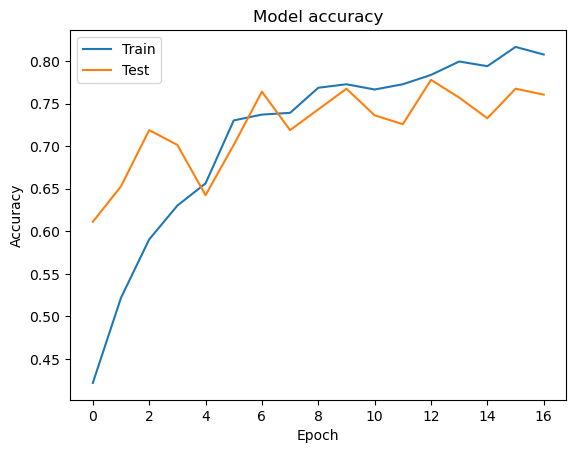

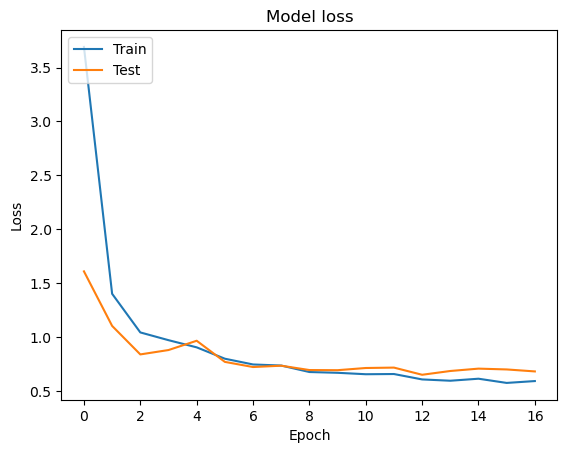

In [18]:
# Plotting accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plotting loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Testing


In [19]:
# Get the class indices
class_indices = test_generator.class_indices

# Get the first batch of data from the test generator
x_test, y_test = next(test_generator)

# Use the model to make predictions on the first batch of test data
predictions = model.predict(x_test)


1/1 [==============================] - 2s 2s/step


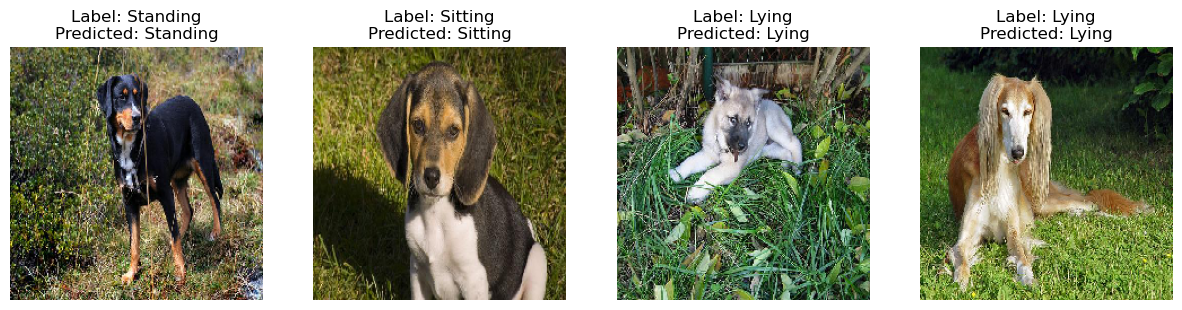

In [20]:
# Visualize the images, labels, and predictions
fig, axes = plt.subplots(nrows=len(x_test)%4 +1, ncols=4, figsize=(15,15))
for i, ax in enumerate(axes.flat):
    ax.imshow(x_test[i])
    # Use a dictionary comprehension to get the keys that correspond to the value
    true_labels = [key for key, value in class_indices.items() if value == y_test[i].argmax()]
    prediction_labels = [key for key, value in class_indices.items() if value == predictions[i].argmax()]

    ax.set_title('Label: {}\nPredicted: {}'.format(true_labels[0], prediction_labels[0]))
    ax.axis('off')

In [21]:
# Make predictions using the test generator
full_predictions = model.predict(test_generator, steps=len(test_generator))
predicted_classes = np.argmax(full_predictions, axis=1)

# Get the ground truth labels (true_classes) from the test generator
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Calculate the accuracy score
accuracy = accuracy_score(true_classes, predicted_classes)
print("Test Accuracy:", accuracy)

10/10 [==============================] - 3s 153ms/step
Test Accuracy: 0.7702702702702703


In [22]:
# Calculate the classification report (precision, recall, F1-score, support)
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("\nClassification Report:\n", report)


Classification Report:
               precision    recall  f1-score   support

       Lying       0.71      0.75      0.73        20
     Sitting       0.81      0.71      0.76        35
    Standing       0.77      0.89      0.83        19

    accuracy                           0.77        74
   macro avg       0.76      0.79      0.77        74
weighted avg       0.77      0.77      0.77        74



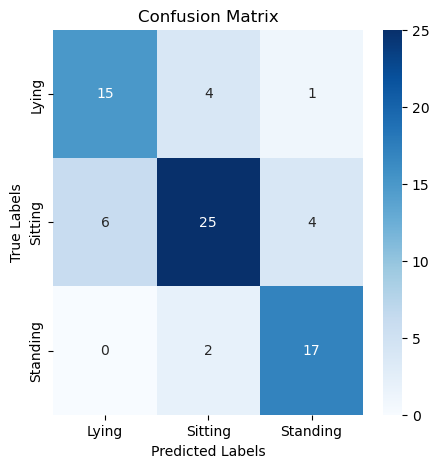

In [23]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
# Plot the confusion matrix as a heatmap
plt.figure(figsize=(5, 5))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

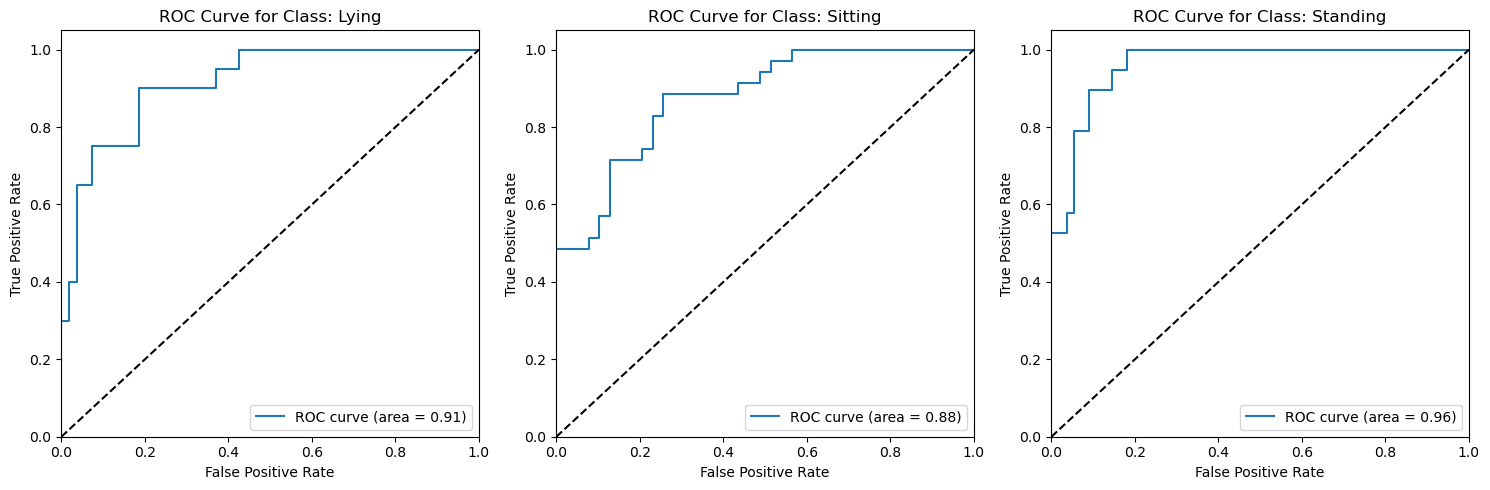

In [24]:
# Get the ground truth labels (true_classes) from the test generator
n_classes = len(test_generator.class_indices)

# Binarize the true_classes to match the shape of the predictions
y_true = label_binarize(true_classes, classes=np.arange(n_classes))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], full_predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curve for each class in separate subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes = axes.ravel()

for i in range(n_classes):
    axes[i].plot(fpr[i], tpr[i], label='ROC curve (area = {0:0.2f})'.format(roc_auc[i]))
    axes[i].plot([0, 1], [0, 1], 'k--')
    axes[i].set_xlim([0.0, 1.0])
    axes[i].set_ylim([0.0, 1.05])
    axes[i].set_xlabel('False Positive Rate')
    axes[i].set_ylabel('True Positive Rate')
    axes[i].set_title('ROC Curve for Class: {}'.format(class_labels[i]))
    axes[i].legend(loc="lower right")

# Adjust the layout
fig.tight_layout()
plt.show()